<a href="https://colab.research.google.com/github/SoniaVG/Reinforcement-Learning-IA/blob/main/MountainCar_deep_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
url_imagen = "https://www.gymlibrary.dev/_images/mountain_car.gif"
car = "go.gif" # El nombre con el que queremos guardarla
imagen = requests.get(url_imagen).content
with open(car, 'wb') as handler:
	handler.write(imagen)

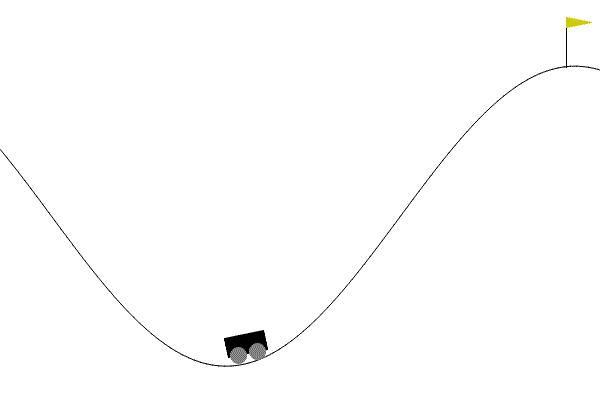

# Description of the problem:

https://www.gymlibrary.dev/environments/classic_control/mountain_car/



\begin{array}{|l|l|}
\hline
\text{Action Space}   & \text{Discrete(3)}                \\ \hline
\text{Observation Shape}  & (2,)                       \\ \hline
\text{Observation High }  & [0.6, 0.07]                 \\ \hline
\text{Observation Low} & [-1.2 ,-0.07]               \\ \hline
\text{Import}  & \text{gym.make("MountainCar-v0")} \\ \hline
\end{array}



In [3]:
from IPython.display import clear_output
!pip install gymnasium
%matplotlib inline
clear_output()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

Acciones: Discrete(2)
dimensión de los estados: (4,)


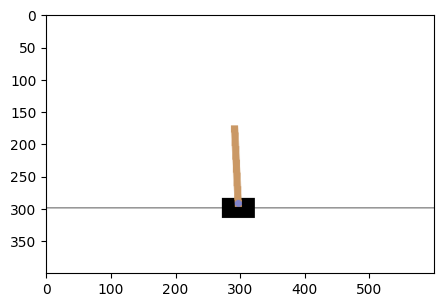

In [7]:
env=gym.make('CartPole-v1', render_mode="rgb_array")

env.reset()[0]
plt.figure(figsize = (5,5))
plt.imshow(env.render())
env.close()

print("Acciones:", env.action_space)
print("dimensión de los estados:", env.observation_space.shape)
# posición de cartpol
# velocidad horizontal
# angulo
# velocidad a la que cae el cartpol

In [8]:
import torch
import torch. nn as nn
from torch.optim import AdamW
import copy
import random
from pickleshare import stat
import torch.nn.functional as F
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [9]:
# PREPROSESAMINETO
class PreprosessEnv(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self):
    state = self.env.reset()[0]

    # Ajuste para trabar con baches, estados: [[1,2],[0.0, 1.0]], acciones [[2],[0]]
    # i.e. es dar dimensión a los esatdos y a las acciones
    return torch.from_numpy(state).unsqueeze(dim=0).float()


  def step(self,action):
    action = action.item()
    next_state, reward, done, info1,  info2= self.env.step(action)
    #print("next_state", next_state)
    next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
    #print("next_state", next_state)
    reward = torch.tensor(reward).view(1,-1).float()#[[0.]]
    #print("reward",reward)
    done =  torch.tensor(done).view(1,-1)
    return next_state, reward, done, info1, info2

env=gym.make('CartPole-v1', render_mode="rgb_array")
env =  PreprosessEnv(env)

In [10]:
env.reset()

tensor([[ 0.0360,  0.0107, -0.0470, -0.0397]])

In [11]:
# crear Q-network
state_dim = 4
num_actions = 2

q_network = nn.Sequential(
    #capa de entrada
    nn.Linear(state_dim, 128),
    nn.ReLU(),

    nn.Linear(128, 64),
    nn.ReLU(),

    nn.Linear(64, num_actions)
)

In [12]:
class ReplayMemory():
  def __init__(self, capacity=1000000):
    self.capacity = capacity
    self.memory = []
    self.position = 0

    #insert [s,a,r,s']
  def insert(self, transition):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = transition
    self.position = (self.position+1)% self.capacity

   #sample [[s,a,r,s'],[s,a,r,s']]
  def sample(self, batch_size):
     assert self.can_sample(batch_size)
     batch = random.sample(self.memory, batch_size) #crear bloques de tamaño batch_size

   #[[s,a,r,s'],[s,a,r,s'],[s,a,r,s'],[s,a,r,s']] --->[[s,s,s,s],[a,a,a,a]] juntar estados y acciones juntas
     batch = zip(*batch) #* es para desempaquetar
     return [torch.cat(items) for items in batch]

  def can_sample(self, batch_size):
    return len(self.memory) >= batch_size * 10

  def __len__(self):
    return len(self.memory)

In [13]:
# crear target Q-network
# En este caso, vamos a utilizar una red objetivo que es una red neuronal.
# que no participará en el proceso de aprendizaje y cuyo único propósito es calcular los valores objetivo
# para la regla de actualización.


target_q_network = copy.deepcopy(q_network) #crear copia
target_q_network = target_q_network.eval() #Para evitar las predicciones de esta red neuronal participan en el proceso de aprendizaje.
print(target_q_network)

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
def policy(state, epsilon = 0.):
    #print(epsilon)
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach() #Q value para casa estado
        return torch.argmax(av, dim=-1, keepdim=True)

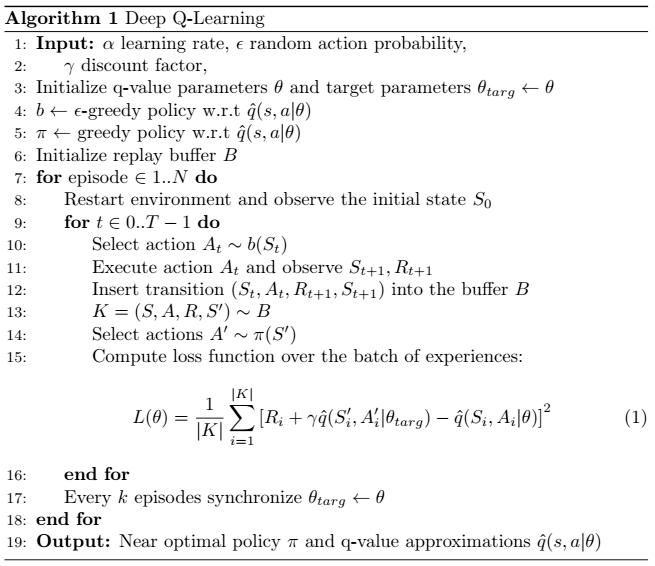

In [15]:
#b es politica e-gredy
# pi= q_network es la otra politica que regresa el valor del q-value máximo
def deep_Q_learning(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.2):

  optimizador = AdamW(q_network.parameters(), lr = alpha)
  memory =  ReplayMemory(capacity=1000000)
  stats = {"MSE Loss":[], "Returns": []}

  for episode in tqdm(range(episodes+1)):
    state = env.reset()
    done = False
    ep_return = 0.

    while not done: # hasta que done = verdadero
      action = policy(state, epsilon)
      next_state, reward, done, _, _ = env.step(action)
      memory.insert([state, action, reward, done, next_state])

      if memory.can_sample(batch_size): #bloques
        state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)

        qsa_b = q_network(state_b).gather(1, action_b)

        next_qsa_b = target_q_network(next_state_b)
        next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0] #maximos por fila manteniendo la dimensión

        target_b = reward_b + ~done_b* gamma * next_qsa_b


        loss = F.mse_loss(qsa_b, target_b)
        q_network.zero_grad() #borramos los gradientes que calculamos
        loss.backward() #calculamos los gradientes de la función de costo
        optimizador.step() # actualizamos los valores de los parametros de la red

        stats["MSE Loss"].append(loss.item())

      state = next_state
      ep_return +=reward.item()

    stats["Returns"].append(ep_return)

    if episode % 10 == 0:
      #Actualizaremos los valores de la red neuronal objetivo cada diez episodios, copiando los valores de
      #la red que está aprendiendo en la red de destino.
      target_q_network.load_state_dict(q_network.state_dict())

  return stats

In [16]:
stats = deep_Q_learning(q_network, policy, 200, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.2)

100%|██████████| 201/201 [00:52<00:00,  3.85it/s]


In [17]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(8, 5))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

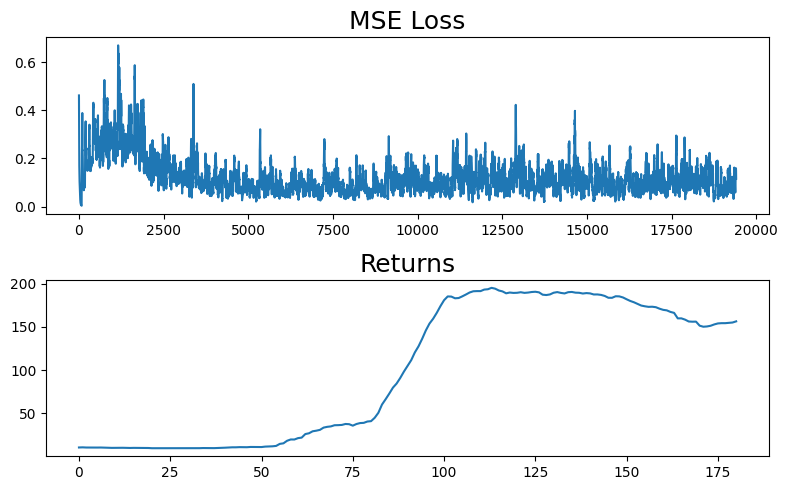

In [18]:
plot_stats(stats)

In [19]:
def test_agent(env, policy, episodes= 10):
    plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render())
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _, _ = env.step(action)
            img.set_data(env.render())
            plt.axis('off')
            display(plt.gcf())
            clear_output(wait=True)
            state = next_state

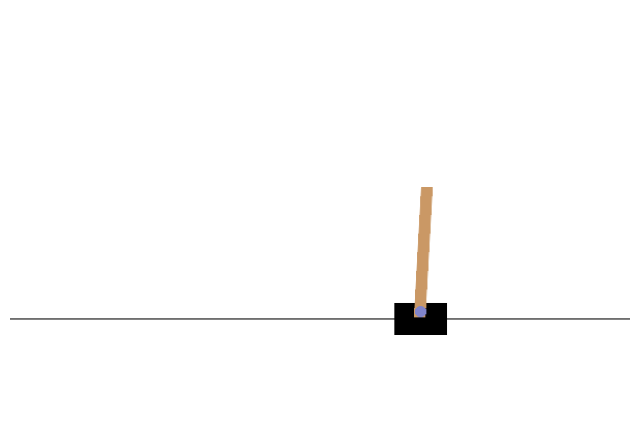

In [ ]:
test_agent(env, policy, episodes= 1)